## Recognize Anything Model + Grounding Dino
Demo Notebooks SAM and Grounded DINO
- https://github.com/xinyu1205/recognize-anything/blob/main/recognize_anything_demo.ipynb
- https://github.com/xinyu1205/recognize-anything/blob/main/gui_demo.ipynb


In [1]:
import os
import sys
import torch

import numpy as np

import matplotlib.pyplot as plt
from functools import partial
import glob

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from timm.models.vision_transformer import PatchEmbed, Block
from PIL import Image, ImageDraw, ImageFont

from ram_gdino import (
    extract_objects_from_bounding_boxes,
    detect_objects_with_ram,
    # get_grounding_output,
    inference,
    load_ram,
    load_tag2text,
    load_grounding_dino,
    draw_box,
    # predict_batch
    # load_sam
)
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
import groundingdino.datasets.transforms as T
from groundingdino.util.inference import predict, load_image, annotate
from ram import inference_ram

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### UDFs

In [2]:
def inference_ram_batch(image, model):
    with torch.no_grad():
        tags = model.generate_tags_for_batch(image)

    return tags[0]

In [3]:
def process_tags(raw_tags: list):
    # Convert raw_tags into a single list of all words, then get unique words
    all_words = [
        tag.strip()
        for sublist in [tags.split(" | ") for tags in raw_tags]
        for tag in sublist
    ]
    unique_words = list(set(all_words))

    # Convert list back to a string
    raw_tags = ", ".join(sorted(unique_words, key=str.lower))

    if not raw_tags.endswith("."):
        raw_tags = raw_tags + "."

    return raw_tags

### Let's resize images for tagging

In [4]:
import torchvision.transforms as TS

NORMALIZE = TS.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
TAGGING_TRANSFORM = TS.Compose([TS.Resize((384, 384)), TS.ToTensor(), NORMALIZE])
GROUNDING_TRANSFORM = T.Compose(
    [
        T.RandomResize([800], max_size=1333),
        # T.Resize((800, 1200)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = glob.glob(os.path.join(root_dir, "demo*.jpg"))
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.image_paths)

In [5]:
%%time

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Create the dataset
dataset = ImageDataset("./assets", transform=TAGGING_TRANSFORM)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=1, num_workers=6)

# Iterate over the DataLoader
for images in dataloader:
    images = images.cuda()
    # GROUNDING_TRANSFORM(stacked_images).unsqueeze(0).to(device)

print(images.shape)
print(images.device)

torch.Size([1, 3, 384, 384])
cuda:0
CPU times: user 1.02 s, sys: 1.46 s, total: 2.48 s
Wall time: 10.1 s


In [6]:
%%capture
# usually takes around 1min on RTX 3090
ram_model = load_ram(device)
grounding_dino_model = load_grounding_dino(device)

ram_model = ram_model.to(device)
grounding_dino_model = grounding_dino_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# Read in images
images = []
img_paths = []

for i in range(1, 25):
    img_path = f"./assets/demo{i}.jpg"
    in_img = Image.open(img_path)
    images.append(in_img)
    img_paths.append(img_path)

len(images), len(img_paths)

(24, 24)

#### Perform inference RAM (single image)
- takes 241ms for a batch of 8 to perform inference - **30ms / frame**
- 750ms for 24 images
- could be optimized using batch inference

In [8]:
def inference_with_ram(img, do_det_seg):
    return inference(
        img,
        None,
        do_det_seg,
        "RAM",
        ram_model,
        grounding_dino_model,
        label_with_probab=False,
        device=device,
    )

Start processing, image size (2068, 1450)
Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water


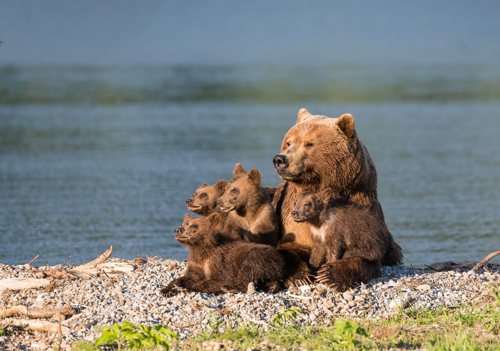

Start processing, image size (2048, 1365)
Tags:  brown, chase, sheepdog, corgi, dog, field, grass, grassy, neckband, red, run, white


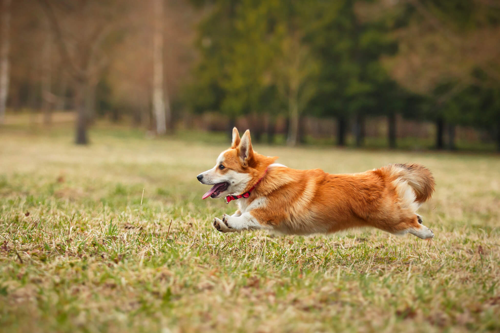

Start processing, image size (3295, 1846)
Tags:  bar stool, chair, color, draw, floor, mall, stool, store


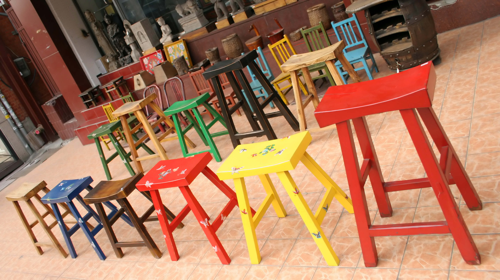

Start processing, image size (1072, 603)
Tags:  beach, black, brown, carry, chase, dog, mouth, sea, play, run, sand, stick, toy


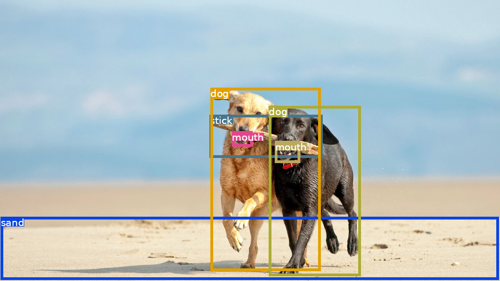

Start processing, image size (3000, 1999)
Tags:  ball, bat, cricket, cricket team, cricketer, game, man, play, player, referee, stand, test, wicket


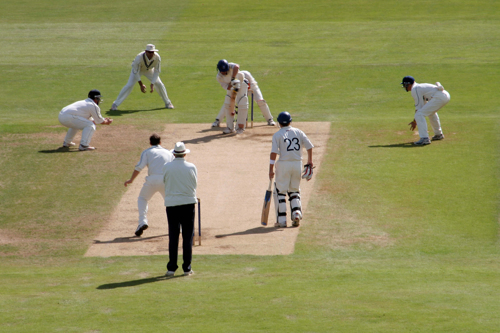

Start processing, image size (2048, 1364)
Tags:  cat, floor, jump, paw, play, stand


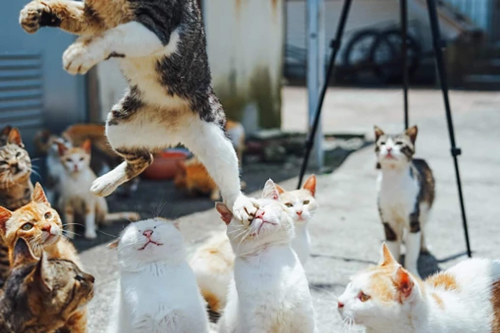

Start processing, image size (2048, 1367)
Tags:  dust, field, horse, grassy, herd, hillside, lush, plain, run, wild


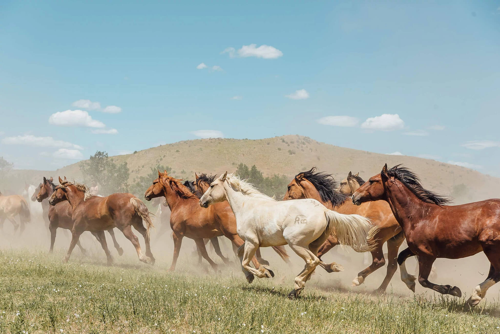

Start processing, image size (2500, 1661)
Tags:  figurine, frog, green, log, miniature, puddle, reflection, stone, sit, snail, tortoise, tree frog, turtle, water


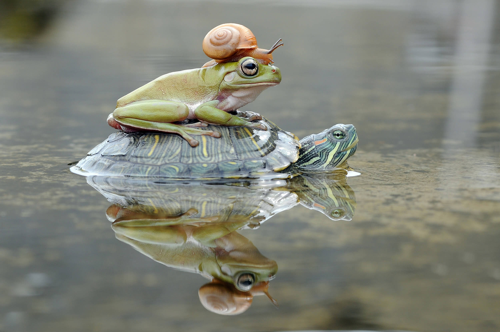

CPU times: user 4.75 s, sys: 98.8 ms, total: 4.85 s
Wall time: 4.15 s


In [13]:
%%time
for i in range(1, 9):
    # Open Image
    in_img = Image.open(f"./assets/demo{i}.jpg")
    # print("-----\n")
    raw_image = in_img.convert("RGB")

    ram_tags, ram_out_image, pred_phrases, boxes_filt = inference_with_ram(
        in_img, do_det_seg=True
    )

    # # Display image
    ram_out_image.thumbnail((500, 500))
    display(ram_out_image.convert("RGB"))

    # # Get object images from using bounding boxes
    current_object_images = extract_objects_from_bounding_boxes(in_img, boxes_filt)

    # Save images to list
    # objects_pool.extend([(obj, phrase[0]) for obj, phrase in zip(current_object_images, pred_phrases)])

    # Save object images to folder
    # for idx, obj_image in enumerate(current_object_images, start=1):
    #     save_path = os.path.join(objects_pool_path, f"demo{i}_object{idx}.jpg")
    #     obj_image.convert("RGB").save(save_path)

#### Batch inference Grounding Dino
- This repo mentions what changes need to be made to current codebase in Grounding_dino: https://github.com/yuwenmichael/Grounding-DINO-Batch-Inference

In [ ]:
%%time
# Convert your list of image tensors into a single tensor representing the batch
# image_batch = torch.stack(image_tensors).unsqueeze(0).to(device)
with torch.no_grad():
    # Assuming you have an instance of the class containing the `generate_tags_for_batch` function called `model_instance`
    tags = ram_model.generate_tags_for_batch(images)
    # print(tags)

In [ ]:
captions = process_tags(tags)
captions

In [ ]:
def predict_batch(
    model,
    images: torch.Tensor,
    caption: str,
    box_threshold: float,
    text_threshold: float,
    device: str = "cuda",
    debug: bool = False,
):
    """
    return:
        bboxes_batch: list of tensors of shape (n, 4)
        predicts_batch: list of tensors of shape (n,)
        phrases_batch: list of list of strings of shape (n,)
        n is the number of boxes in one image
    """
    # caption = preprocess_caption(caption=caption)
    # model = model.to(device)
    image = images.to(device)
    with torch.no_grad():
        outputs = model(
            image, captions=[caption for _ in range(len(images))]
        )  # <------- I use the same caption for all the images for my use-case
    prediction_logits = outputs[
        "pred_logits"
    ].sigmoid()  # prediction_logits.shape = (num_batch, nq, 256)
    prediction_boxes = outputs[
        "pred_boxes"
    ]  # prediction_boxes.shape = (num_batch, nq, 4)

    # import ipdb; ipdb.set_trace()
    mask = (
        prediction_logits.max(dim=2)[0] > box_threshold
    )  # mask: torch.Size([num_batch, 256])

    bboxes_batch = []
    predicts_batch = []
    phrases_batch = []  # list of lists
    tokenizer = model.tokenizer
    tokenized = tokenizer(caption)
    for i in range(prediction_logits.shape[0]):
        logits = prediction_logits[i][mask[i]]  # logits.shape = (n, 256)
        phrases = [
            get_phrases_from_posmap(
                logit > text_threshold, tokenized, tokenizer
            ).replace(".", "")
            for logit in logits  # logit is a tensor of shape (256,) torch.Size([256])  # torch.Size([7, 256])
        ]
        boxes = prediction_boxes[i][mask[i]]  # boxes.shape = (n, 4)
        phrases_batch.append(phrases)
        bboxes_batch.append(boxes)
        predicts_batch.append(logits.max(dim=1)[0])

        if debug:
            image_draw = ImageDraw.Draw(raw_image)
            for box, label in zip(boxes, phrases):
                draw_box(box, image_draw, label)

    return bboxes_batch, predicts_batch, phrases_batch

In [ ]:
%%timeit
boxes, logits, phrases = predict_batch(
    model=grounding_dino_model,
    images=images,
    caption=captions,
    box_threshold=0.25,
    text_threshold=0.2,
    debug=False,  # TODO: Fix debug!
)

In [ ]:
print(len(boxes), len(logits), len(phrases))